# 🌀 Class Practice: OLR Regression and MJO Propagation

In this notebook, you'll walk through the key steps of extracting eastward-propagating signals of the MJO using OLR regression.

**Objectives:**
- Understand anomaly calculation and seasonal cycle removal
- Apply bandpass filter to isolate intraseasonal signal
- Perform lagged regression and generate a Hovmöller diagram

## 📦 Step 1: Import necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy.signal import butter, filtfilt
from matplotlib.colors import TwoSlopeNorm

## 📂 Step 2: Load NetCDF data
We are using FLNT (proxy for OLR), U850, and coordinates from TaiESM model output.

In [2]:
with Dataset("f09.F2000_MJO_1year.cam.h0.subset_MJO_vars.nc") as f:
    Q = f["FLNT"][:]
    u850 = f["U850"][:]
    lat = f["lat"][:]
    lon = f["lon"][:]
    time = f["time"][:]

## 🎚️ Step 3: Remove seasonal cycle and apply bandpass filter
These helper functions are provided. Please review their structure.

In [3]:
def band_pass_filter(data, lowcut=1/90, highcut=1/50, fs=1):
    nyq = 0.5 * fs
    b, a = butter(2, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data, axis=0)

def remove_seasonal_cycle(Q, num_harmonics=3):
    """
    Remove seasonal cycle using low-order Fourier harmonics.
    Supports input shape (time, lon) or (time, lat, lon).
    """
    ntime = Q.shape[0]
    t = np.arange(ntime)

    # Create time basis
    Q_detrended = Q.copy()
    for h in range(1, num_harmonics + 1):
        freq = 2 * np.pi * h / ntime
        cos_term = np.cos(freq * t)
        sin_term = np.sin(freq * t)

        if Q.ndim == 2:  # (time, lon)
            cos_term = cos_term[:, None]
            sin_term = sin_term[:, None]
            a = (Q * cos_term).mean(axis=0)
            b = (Q * sin_term).mean(axis=0)
            Q_detrended -= a[None, :] * cos_term
            Q_detrended -= b[None, :] * sin_term

        elif Q.ndim == 3:  # (time, lat, lon)
            cos_term = cos_term[:, None, None]
            sin_term = sin_term[:, None, None]
            a = (Q * cos_term).mean(axis=0)
            b = (Q * sin_term).mean(axis=0)
            Q_detrended -= a[None, :, :] * cos_term
            Q_detrended -= b[None, :, :] * sin_term

        else:
            raise ValueError("Input Q must be 2D or 3D (time, lon) or (time, lat, lon)")

    return Q_detrended

In [4]:
def preprocess_Q(Q, lat, lat_band=(-15, 15)):
    """
    Global anomaly → Remove seasonal cycle → Lat restrict + cos-weighted mean → Bandpass filter.
    Input:
        Q: (time, lat, lon)
        lat: (lat,)
    Returns:
        Q_filtered: (time, lon)
    """
    # Step 1: global anomaly (remove time mean at each grid point)
    Q_anom = Q - Q.mean(axis=0)

    # Step 2: remove seasonal cycle (grid-point wise)
    Q_deseasonal = remove_seasonal_cycle(Q_anom, num_harmonics=3)  # shape: (time, lat, lon)

    # Step 3: restrict latitude and do weighted average
    lat_mask = (lat >= lat_band[0]) & (lat <= lat_band[1])
    lat_sel = lat[lat_mask]
    weights = np.cos(np.deg2rad(lat_sel))
    weights /= weights.sum()

    Q_sel = Q_deseasonal[:, lat_mask, :]  # shape: (time, lat_subset, lon)
    Q_eq = np.average(Q_sel, axis=1, weights=weights)  # shape: (time, lon)

    # Step 4: band-pass filter
    Q_filtered = band_pass_filter(Q_eq)

    return Q_filtered

## 📈 Step 4: Preprocess FLNT and U850

In [5]:
# Apply preprocessing to FLNT and U850
Q_filtered = preprocess_Q(Q, lat, lat_band=(-15, 15))
u850_filtered = preprocess_Q(u850, lat, lat_band=(-15, 15))

## 📉 Step 5: Lagged Regression
Here we regress FLNT(t+lag, lon) onto a reference time series (e.g. FLNT averaged over 75–80°E).

The function below computes regression slopes α(lag, lon).

In [6]:
def lagged_regression_against_reference(Q, ref_series, lags=np.arange(-20, 21)):
    """
    Regress Q(t, lon) ~ ref_series(t + lag)

    Parameters:
        Q: (time, lon) full field
        ref_series: (time,) reference time series
        lags: list of lags

    Returns:
        reg_map: (len(lags), lon)
    """
    nt, nlon = Q.shape
    reg_map = np.full((len(lags), nlon), np.nan)

    for i, lag in enumerate(lags):
        t = np.arange(nt)
        t_lag = t + lag
        valid = (t_lag >= 0) & (t_lag < nt)

        x = ref_series[...] # ← 請填入 t_lag[valid] 或 t[valid] 中的哪一個？
        y = Q[...]          # ← 請填入 t_lag[valid] 或 t[valid] 中的哪一個？

        cov = np.mean(x[:, None] * y, axis=0)
        var = np.mean(x ** 2)
        reg_map[i] = cov / var if var > 0 else 0

    return reg_map

## 🌍 Step 6: Plot Hovmöller Diagram

(366, 288)


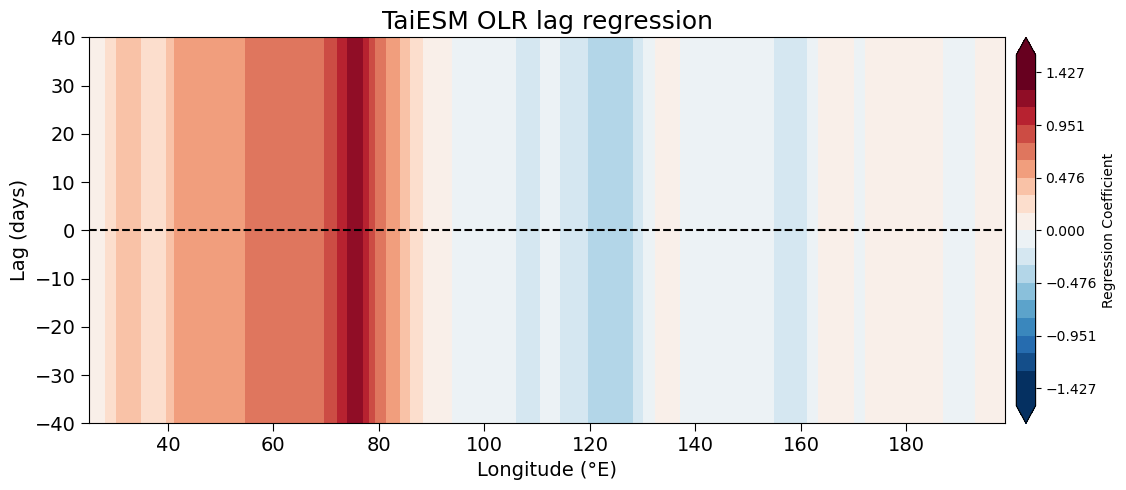

In [7]:
# Step. 0: Make sure the dimension of Q_filtered
print(Q_filtered.shape)

# Step 1: 平均 Q_filtered 在 75–80°E 區間
ref_mask = (lon >= 75) & (lon <= 80)
ref_series = Q_filtered[:, ref_mask].mean(axis=1)  # shape: (time,)

# Step 2: 做回歸
reg_map = lagged_regression_against_reference(Q_filtered, ref_series, lags=np.arange(-40, 41))

# Step 3: 畫圖
fig, ax = plt.subplots(1, figsize=(12, 5))
vabs = np.nanmax(np.abs(reg_map))
norm = TwoSlopeNorm(vmin=-vabs-0.15, vcenter=0, vmax=vabs+0.15)

cf = ax.contourf(
    lon[20:160], np.arange(-40, 41), reg_map[:, 20:160],
    levels=np.linspace(-vabs-0.4, vabs+0.4, 21),
    cmap="RdBu_r", norm=norm, extend="both"
)

ax.axhline(0, color='k', linestyle='--')
ax.set_xlabel("Longitude (°E)", fontsize=14)
ax.set_ylabel("Lag (days)", fontsize=14)
ax.set_title("TaiESM OLR lag regression", fontsize=18)
ax.tick_params(axis='both', labelsize=14, direction='out', length=6)
cbar = fig.colorbar(cf, ax=ax, label="Regression Coefficient", pad=0.01)
plt.tight_layout()
plt.show()




## ✅ Summary
- You processed full-field OLR and U850
- Removed seasonal cycle and filtered intraseasonal signals
- Performed lagged regression and visualized MJO propagation

🎯 *Challenge: Try different reference longitudes or apply same method to U850!*